# Technical Appendix

In [2]:
# Importing requisite libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
data = pd.read_csv("responses_n.csv")

# Fuzzy match on countries :: 4 countries
data["Country where you (and the grocery store) are"].replace(
    {
        "Berlin": "Germany",
        "United Kingdom": "UK",
        "London": "UK",
        "United Kindom": "UK",
        "Berlin, Germany": "Germany",
        "Germany ": "Germany",
        "United Kingdom ": "UK",
        "Berlin, Germany ": "Germany"
    },
    inplace = True
    )



# Correcting the WOO anomaly
data.loc[data["Currency (e.g. EUR, GBP, USD)"] == "Korean Won", "Currency (e.g. EUR, GBP, USD)"] = "USD"

# Slice out price df and quantity df
prices = data.iloc[:,10::2]
quantities = data.iloc[:,9::2]

conversion_rates = {
        'EUR': 1,
        'GBP': 0.95,
        'USD': 0.91
    }

# Create exchange rate column
data['Exchange Rate'] = data.iloc[:, 5].apply(lambda x: conversion_rates[x])

# Convert to Euros
euro_prices = prices.mul(data['Exchange Rate'], axis = 0)
# Drop exchange rate column before we melt
# euro_prices = euro_prices.drop('Exchange Rate', axis = 0, inplace = True)

# Standardizing prices 
# :: cts for eggs will be microscopic but we can rescale later
std_prices = euro_prices.div(quantities.values)

# Melt to (N*10*3, 2)
flush_prices = pd.melt(std_prices)

# Recasting item names in main roles
items = ['Apples', 'Bananas', 'Tomatoes',
         'Potatoes', 'Flour', 'Rice', 'Milk',
         'Butter', 'Eggs', 'Chicken Breasts']

flush_prices = flush_prices.replace(
               r'Product [0-9] price$', 0, regex = True).replace(
               r'Product [0-9] price.([0-9])', r'\1', regex = True)

# Change names
flush_prices.variable = flush_prices.variable.astype('int').replace({i : items[i] for i in range(len(items))})

# Add country and brand data, similarly melted
# Perform a Series melt through repetition
countries = data["Country where you (and the grocery store) are"].repeat(prices.shape[1])
brands = data["Price perception of the store brand"].repeat(prices.shape[1])
neighbordhoods = data["Neighborhood"].repeat(prices.shape[1])
rents = data["Average rental price near the grocery store"].repeat(prices.shape[1])

# Check shape
brands.value_counts() == data["Price perception of the store brand"].value_counts()*30
# Check the order for a selection
#assert data.iloc[4,6] == brands.iloc[4*90]

# We can now safely drop NAs, without dropping rows
#straight_prices = flush_prices.dropna(axis = 0)
#assert len(flush_prices.loc[flush_prices['variable'] == 0]) == data.shape[0]*3

Mid-range             True
Budget (cheap)        True
Luxury (expensive)    True
Name: Price perception of the store brand, dtype: bool

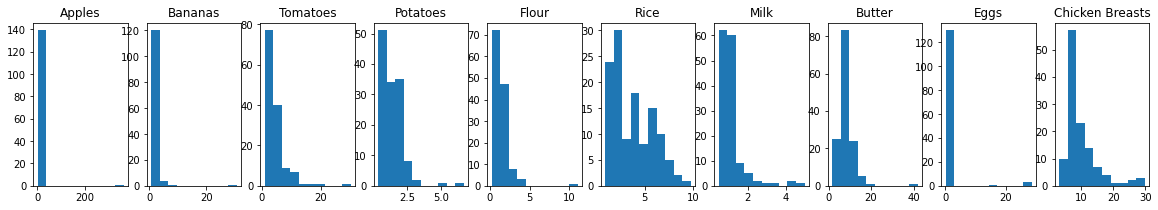

In [14]:
fig, axs = plt.subplots(ncols=10, figsize = (20,3))

for item, ax in zip(items, axs.flatten()):

    ax.hist(flush_prices.loc[flush_prices['variable'] == item, 'value'])
    ax.set_title(f'{item}')

In [ ]:
# Reset index to support concat
countries = countries.reset_index().drop('index', axis = 1)
brands = brands.reset_index().drop('index', axis = 1)
neighbordhoods = neighbordhoods.reset_index().drop('index', axis = 1)

model_data = pd.concat((flush_prices, countries, brands, neighbordhoods), axis = 1)

# Remove outliers
# Kill the $300/kg Apple
poison_apple = 52
# Humpty dumpty to the expensive eggs
expensive_eggs = model_data.loc[(model_data.variable == "Eggs") & (model_data.value > 5), :].index
bougie_butter = model_data.loc[(model_data.variable == "Butter") & (model_data.value > 22), :].index
bad_banana = model_data.loc[(model_data.variable == "Bananas") & (model_data.value > 10), :].index
rotten_tomato = model_data.loc[(model_data.variable == "Tomatoes") & (model_data.value > 10), :].index
stale_flour = model_data.loc[(model_data.variable == "Flour") & (model_data.value > 13), :].index
bad_potato = model_data.loc[(model_data.variable == "Potatoes") & (model_data.value > 13), :].index


model_data = model_data.drop([*expensive_eggs, poison_apple, *bougie_butter, *bad_banana, *rotten_tomato, *stale_flour, *bad_potato])

# See if extreme values are sensible
extrema = model_data.value.dropna().sort_values()[-10:]
#print(clean_prices.loc[extrema.index, :])

# Safely drop nas now that rows are aligned
model_data.dropna(axis = 0, inplace=True)

# Should just have Germany now
model_data.Neighborhood.unique()

## Fitting the Stan Model

To correctly bound indexing in the Stan code, each independent variable is assigned its category code. With a well-parsed data frame, we simply need to extract column values to pass to Stan in `model_data`

In [24]:
# Reset index to support concat
countries = countries.reset_index().drop('index', axis = 1)
brands = brands.reset_index().drop('index', axis = 1)
neighbordhoods = neighbordhoods.reset_index().drop('index', axis = 1)


model_data = pd.concat((flush_prices, countries, brands, neighbordhoods), axis = 1)

# Safely drop nas now that rows are aligned
model_data.dropna(axis = 0, inplace=True)


# Label Encoding
cat_params = ["Country where you (and the grocery store) are", "Price perception of the store brand", "variable", "Neighborhood" ]
model_data.loc[:, cat_params] = model_data.loc[:, cat_params].astype('category')

for cat in cat_params:
    model_data[cat] = model_data[cat].cat.codes

In [25]:
model_data

,variable,value,Country where you (and the grocery store) are,Price perception of the store brand,Neighborhood
0,0,2.99,1,0,4
1,0,1.59,1,0,4
2,0,3.49,1,0,4
3,0,2.99,1,0,4
4,0,2.99,1,0,4
...,...,...,...,...,...
1015,3,0.72,1,0,7
1016,3,1.29,1,0,7
1017,3,0.99,1,0,7
1018,3,1.15,1,0,7


In [2]:
sc = """
data {
    int<lower = 1> N; 
    real<lower = 0> prices[N];
    
    // arrays with param labels, starting at 1
    int<lower = 1, upper = 10> products[N];
    int<lower = 1, upper = 7> neighborhoods[N];
    int<lower = 1, upper = 3> brand[N];
}

parameters {
    real<lower = 0> base_price[10];
    real<lower = 0> country_mul[7];
    real<lower = 0> brand_mul[3];

    real<lower = 0> price_sigma[10];  // error in likelihood
}

model {

    base_price ~ cauchy(0,100);

    country_mul ~ lognormal(0,0.25);
    brand_mul ~ lognormal(0,0.25);

    price_sigma ~ inv_gamma(2.5,2);

    for (i in 1:N) {
        prices[i] ~ normal(base_price[products[i]]* \
                           country_mul[neighborhoods[i]]* \ 
                           brand_mul[brand[i]],\ 
                           price_sigma[products[i]]);
    }
}

"""

In [ ]:
model_data = {
    'N': model_data.shape[0],
    'prices': model_data.value.values,
    'products': model_data.variable.values,
    'neighborhoods': model_data["Neighborhood"].values,
    'brands': model_data["Price perception of the store brand"].values
}

model = pystan.StanModel(model_code = sc)
results = model.sampling(data = model_data)

samples = results.extract()

![Stan Output](/Users/andrevacha/Desktop/cs146/LBA/output.png)

## Results Visualization

Code to reproduce the plots is given below. In each case, the concept for the plot is inherited from code observed in class.

In [ ]:
# Base Prices
base_samples = samples['base_price'].T

zipped_samples = zip(label['variable'].values(), base_samples)
sorted_samples = sorted(zipped_samples, key = lambda x: x[1].mean())

prod_samples = np.transpose(sorted_samples)

fig = plt.figure(figsize=(11,6))

for i, product_samples in enumerate(prod_samples[1]):
  x = sts.uniform.rvs(loc = i+1-0.15, scale = 0.3, size = 4000)
  y = product_samples

  plt.plot(x,y,',', alpha = 0.1)

  # plot a marker for the mean
  plt.plot(i+1,np.mean(y), marker = "+", color = "black")

plt.xticks(ticks=range(1,11), labels= prod_samples[0])
plt.xlabel("Product")
plt.ylabel("Base Price")
plt.title("Base Prices for Products")

plt.show()

In [ ]:
# Multipliers Pair Plot
fig,axs = plt.subplots(figsize=(10,5), nrows = 1, ncols = 2, sharey = True)

base_samples = samples['brand_mul'].T

zipped_samples = zip(label['Price perception of the store brand'].values(), base_samples)
sorted_samples = sorted(zipped_samples, key = lambda x: x[1].mean())

prod_samples = np.transpose(sorted_samples)


for i, product_samples in enumerate(prod_samples[1]):
  x = sts.uniform.rvs(loc = i+1-0.15, scale = 0.3, size = 4000)
  y = product_samples

  axs[0].plot(x,y,',', alpha = 0.4)

  # plot a marker for the mean
  axs[0].plot(i+1,np.mean(y), marker = "+", color = "black")

axs[0].set_xticks(range(1, len(prod_samples[0]) + 1))
axs[0].set_xticklabels(prod_samples[0])

axs[0].set_xlabel("Price Perception")
axs[0].set_ylabel("Multiplier")
axs[0].set_title("Brand Multiplier")

base_samples = samples['country_mul'].T

zipped_samples = zip(label['Country where you (and the grocery store) are'].values(), base_samples)
sorted_samples = sorted(zipped_samples, key = lambda x: x[1].mean())

prod_samples = np.transpose(sorted_samples)

for i, product_samples in enumerate(prod_samples[1]):
  x = sts.uniform.rvs(loc = i+1-0.15, scale = 0.3, size = 4000)
  y = product_samples

  axs[1].plot(x,y,',', alpha = 0.4)

  # plot a marker for the mean
  axs[1].plot(i+1,np.mean(y), marker = "+", color = "black")

axs[1].set_xticks(range(1, len(prod_samples[0]) + 1))
axs[1].set_xticklabels(prod_samples[0])

axs[1].set_xlabel("Country")
axs[1].set_title("Country Multiplier")


plt.show()